<h1><center>Universidade Federal da Paraíba - UFPB</h1></center>

<h1><center>Centro de Informática - CI</h1></center>
    
<h1><center>Curso de Engenharia da Computação</h1></center>
    
<h1><center>Introdução a Teoria da Informação - ITI: Parte 2 do Trabalho Prático
</h1></center>

### Alunos: Epitácio Neto, Guilherme Moreira, Kenji Sato

### Matrículas: 11506856, 20160105205, 11514918

### Professor: Derzu Omaia

# Descrição do problema

Parte 2:

Implementar um reconhecedor de padrões baseado em PPM ou LZW. Utilize um banco
de dados previamente rotulado, na etapa de treinamento gere um modelo PPM (árvore)
ou LZW (dicionário) para cada categoria do banco de dados selecionado.
Organize o banco de dados em amostras de treino e classificação utilizando a técnica de
validação cruzada. Isto é, para cada categoria do banco de dados, selecione todas as 
amostras - 1 para treinamento e 1 amostra para classificação, a seleção dessas amostras
deve ser aleatória. Para classificação utilize o algoritmo dos K-Vizinhos mais Próximos
(K-NN, k-nearest neighbors), com k=1, utilizando como métrica de distância o tamanho
do arquivo comprimido. No caso do LZW, outra possibilidade de métrica de distância é a
quantidade de índices utilizado pelo LZW, antes da serialização para bytes. A Figura 1
apresenta esse processo de validação cruzada para um banco de dados de texturas de
imagens.

O treinamento consiste em gerar o dicionário de cada categoria do banco de dados. A
classificação/testes consiste em comprimir 1 amostra (que não foi utilizada na geração do
modelo) em todos os modelos/dicionários. Durante a compressão da amostra de teste o
dicionário deve permanecer estático. A amostra de teste deve ser atribuída ao modelo que
proporcionou a melhor compressão.

No caso do PPM, teste com contexto variável, K = 0, 1, 2, 3, 4, 5, 6, 7, 8. Para o LZW,
teste com dicionários de tamanho 2K, com K= 9, 10, 11, 12, 13, 14, 15, 16. Faça um
relatório e neste apresente as curvas de Taxa de acerto x K, e de Tempo de
Processamento x K, para.

# Introdução

Este relatório tem como proposta a continuação da implementação, em linguagem python, a partir do codificador feito na parte 1 do projeto, fazendo com que ele passe por um processo de Validação Cruzada antes da criação dos dicionários para uso do algoritmo Lempel-Ziv-Welch (LZW). O LZW é um algoritmo de compressão derivado do do algoritmo LZ78, que se baseia na localização e no registro dos padrões de uma determinada estrutura de dados. O algoritmo foi desenvolvido e patenteado em 1984 por Terry Welch.

# Materiais e métodos

A implementação total do algoritmo foi feita em python utilizando o Jupyter Notebook como ambiente de desenvolvimento. Neste ambiente, realizamos todos os testes que serão apresentados nas proximas sessões deste relatório. Para os testes utilizamos a base de dados ORL Faces e, nesta, utilizamos as 40 das 64 pessoas disponíveis no banco, conforme as exigências do projeto. Abrimos a base de dados e, em seguida, recebemos uma lista de bytes que equivalem à representação das imagens. Para o treinamento, utilizamos a validação cruzada e escolhemos as imagens de forma aleatória. Nos certificamos que os testes foram feitos para todos os K (9 a 16). Na sessão da função predict(), definimos, ao fim dela, que iremos selecionar o resultado com a menor quantidade de índices como parâmetro. Após feitos os experimentos, criamos plots que representam os resultados obtidos da Taxa de acertos x K e o tempo de processamento x K, como também foi exigido.

# Desenvolvimento e código

## Bibliotecas utilizadas

In [1]:
import copy
import random
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Funções

In [2]:
def openFiles():
    images= []
    for i in range(1,41):
        imagesTemp = []
        for j in range(1,11):
            with open("orl_faces/s"+str(i)+"/"+str(j)+".pgm", "rb") as binary_file:
                    imagesTemp.append(bytearray(binary_file.read()))
        images.append(imagesTemp)
        
    return images

In [3]:
def encoder(data, k, dicionario):
    
    data = str(data)
    max_tam = pow(2,int(k))
    dicionario_tam = len(dicionario)                 
    string = ""        
    dados_comprimido = []   #armazena os dados comprimidos.

        #comeca LZW | Interando por cada indice no arquivo de entrada
    for indices in data:                     
        concat_indices = string + indices #concatena os indices
        if concat_indices in dicionario:  #verifica se tem o indice atual no dicionario
                string = concat_indices       #armazena o indice atual em string
        else:
            dados_comprimido.append(dicionario) #adiciona a saida o indice atual 
            if(len(dicionario) <= max_tam):  #verifica se o dicionario esta cheio
                dicionario[concat_indices] = dicionario_tam #adiciona ao dicionario o novo simbolo caso o dicionario nao esteja cheio
                dicionario_tam += 1 
            string = indices

    if string in dicionario:
        dados_comprimido.append(dicionario[string])

    return len(dados_comprimido)

In [4]:
def fit(images, k):
    print("Treino K = " + str(k))
    
    for pessoa in range(len(images)):
        print("Treinamento da pessoa: " + str(pessoa+1))
        for image in range(len(images[pessoa])):
            encoder(images[pessoa][image], k, dicionario[pessoa]) 

In [5]:
def predict(images, label, k, taxa_acertos):
    previsoes = []
    
    for pessoa in range(len(images)):
        compressionRates = []
        print("Pessoa: " + str(pessoa+1))
        for categoria in range(len(dicionario)):
            compressionRates.append(encoder(images[pessoa], k, dicionario[categoria]))
        
        previsoes.append(compressionRates.index(sorted(compressionRates)[0]))
    
    count = 0
    for i in range(len(label)):
        if label[i] == previsoes[i]:
            count += 1
    taxa_acertos.append(str(count*100/len(label)))
    print("Acertou " + str(count*100/len(label)) + "%" + " com k=" + str(k))

In [6]:
def crossValidation(images):
    imagem_Aleatoria = []
    label = []
    
    for i in range(len(images)):
        index = random.choice(range(len(images[i])))
        imagem_Aleatoria.append(images[i].pop(index))
        label.append(i)
    return imagem_Aleatoria, label

In [7]:
def main(tempo, taxa_acertos):

    for k in range(9, 17):
        inicio_tempo = time.time()
        images = openFiles()
        train = copy.deepcopy(images)
        print("Faz split entre imagens de treino e teste")
        test, label = crossValidation(train)
        print("Inicia o Treinamento do KNN")
        fit(train, k)
        print("Previsao de categoria das imagens testadas")
        predict(test, label, k, taxa_acertos)
        print("Fim da previsão")
        fim_tempo = time.time()
        print("K = "+str(k)+"%s segundos " % (time.time()-inicio_tempo))
        tempo.append(fim_tempo-inicio_tempo)
    
    

In [8]:
table = {}
for i in range(256):
    table[i] = bytes([ord(chr(i))])
dicionario = [copy.deepcopy(table) for _ in range(40)]

In [9]:
tempo = []
taxa_acertos = []
K = [9, 10, 11, 12, 13, 14, 15, 16]

## Execução

In [10]:
main(tempo, taxa_acertos)

Faz split entre imagens de treino e teste
Inicia o Treinamento do KNN
Treino K = 9
Treinamento da pessoa: 1
Treinamento da pessoa: 2
Treinamento da pessoa: 3
Treinamento da pessoa: 4
Treinamento da pessoa: 5
Treinamento da pessoa: 6
Treinamento da pessoa: 7
Treinamento da pessoa: 8
Treinamento da pessoa: 9
Treinamento da pessoa: 10
Treinamento da pessoa: 11
Treinamento da pessoa: 12
Treinamento da pessoa: 13
Treinamento da pessoa: 14
Treinamento da pessoa: 15
Treinamento da pessoa: 16
Treinamento da pessoa: 17
Treinamento da pessoa: 18
Treinamento da pessoa: 19
Treinamento da pessoa: 20
Treinamento da pessoa: 21
Treinamento da pessoa: 22
Treinamento da pessoa: 23
Treinamento da pessoa: 24
Treinamento da pessoa: 25
Treinamento da pessoa: 26
Treinamento da pessoa: 27
Treinamento da pessoa: 28
Treinamento da pessoa: 29
Treinamento da pessoa: 30
Treinamento da pessoa: 31
Treinamento da pessoa: 32
Treinamento da pessoa: 33
Treinamento da pessoa: 34
Treinamento da pessoa: 35
Treinamento da p

Pessoa: 38
Pessoa: 39
Pessoa: 40
Acertou 32.5% com k=13
Fim da previsão
K = 138.838984489440918 segundos 
Faz split entre imagens de treino e teste
Inicia o Treinamento do KNN
Treino K = 14
Treinamento da pessoa: 1
Treinamento da pessoa: 2
Treinamento da pessoa: 3
Treinamento da pessoa: 4
Treinamento da pessoa: 5
Treinamento da pessoa: 6
Treinamento da pessoa: 7
Treinamento da pessoa: 8
Treinamento da pessoa: 9
Treinamento da pessoa: 10
Treinamento da pessoa: 11
Treinamento da pessoa: 12
Treinamento da pessoa: 13
Treinamento da pessoa: 14
Treinamento da pessoa: 15
Treinamento da pessoa: 16
Treinamento da pessoa: 17
Treinamento da pessoa: 18
Treinamento da pessoa: 19
Treinamento da pessoa: 20
Treinamento da pessoa: 21
Treinamento da pessoa: 22
Treinamento da pessoa: 23
Treinamento da pessoa: 24
Treinamento da pessoa: 25
Treinamento da pessoa: 26
Treinamento da pessoa: 27
Treinamento da pessoa: 28
Treinamento da pessoa: 29
Treinamento da pessoa: 30
Treinamento da pessoa: 31
Treinamento d

## Resultados gráficos

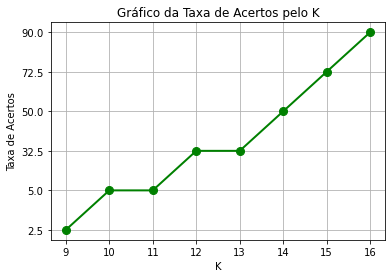

In [11]:
fig, ax = plt.subplots()

ax.plot(K, taxa_acertos, 'go-', linewidth=2, markersize=8)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set(xlabel='K', ylabel='Taxa de Acertos', title='Gráfico da Taxa de Acertos pelo K')
ax.grid()
plt.show()

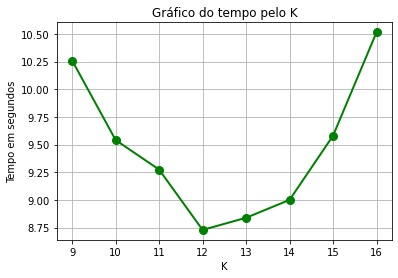

In [12]:
fig, bx = plt.subplots()

bx.plot(K, tempo, 'go-', linewidth=2, markersize=8)
bx.xaxis.set_major_locator(ticker.MultipleLocator(1))
bx.set(xlabel='K', ylabel='Tempo em segundos', title='Gráfico do tempo pelo K')
bx.grid()
plt.show()

# Discussão e conclusão

Notamos que o algoritmo possuiu uma cadência de melhora, com relação aos acertos, ao longo do aumento da variável K, de forma bem considerável. No entanto, podemos ver que o tempo de processamento, para certos valores de K, também aumentam conforme o K aumenta. Dado o percentual de acerto e comparando com a exigência de processamento necessária para a obtenção deste percentual, o custo de programação, ao menos para esta base específica, é justificado pela boa acurácia do algoritmo. Para outros casos, no entanto, podemos obter uma situação em que este custo não justifique em uma melhora suficiente, portanto, é necessário analisar cada caso de forma que tenhamos um equilíbrio entre o um bom tempo de processamento e uma boa taxa de acertos. 

# Referências bibliográficas

ITECHNICA. 6. Dynamic Dictionary - LZW Encoding. Youtube, 9 de Dez. de 2017. Disponível em: https://www.youtube.com/watch?v=14wpPMN-0Fw&ab_channel=itechnica. Acesso em: 15 de Mai. de 2021.

UNIVERSIDADE ESTADUAL DE CAMPINAS - Unicamp. Algoritmo LZW (Lempel-Ziv-Welch). Disponível em:
https://www.decom.fee.unicamp.br/dspcom/EE088/Algoritmo_LZW.pdf. Acesso em: 16 de Mai. de 2021.

SAIKIA, Amartya Ranjan. LZW (Lempel–Ziv–Welch) Compression technique, 9 de Set. de 2019. Disponível em:
https://www.geeksforgeeks.org/lzw-lempel-ziv-welch-compression-technique/. Acesso em: 16 de Mai. de 2021.

LEMPEL–ZIV–WELCH. In: Wikipédia: a enciclopédia livre. Disponível em:.
https://en.wikipedia.org/wiki/Lempel%E2%80%93Ziv%E2%80%93Welch. Acesso em: 16 de Mai. de 2021.

OMAIA, Derzu. Codificadores baseados em Dicionário, 13-15 de Set. de 2021. Notas de Aula.

SANJAI, M. Why and how to Cross Validate a Model?. Disponível em: <https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f>. Acesso em: 22 de Jun. de 2021.

Sem autor: copy in Python (Deep Copy and Shallow Copy). GeeksForGeeks, 2020 (última atualização). Disponível em: <https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/>. Acesso em: 22 de Jun. de 2021.